# <p style="background-color: white; color:black;">Classification Non Supervisée</p>

___

## <u style="color: blue">Sommaire</u>

1. Introduction  
2. Analyse exploratoire  
3. Les algorithmes  
    3.1 K-means  
    3.2 Classification Ascendente Hiérarchique (CAH)  
    3.3 DBSCAN  
4. Evaluation et comparaison des résultats  
5. Profiling client  
6. Conclusion

___

## <u style="color: blue">1. Introduction</u>

Dans ce notebook vous trouverez nos travaux d'utilisation d'algorithmes de Classification Non Supervisée. Dans un premier temps vous trouverez le détail de notre analyse de données puis, une réduction de dimension afin d'utiliser trois algorithmes. A savoir:  
- K-means  
- CAH  
- DBSCAN  

Par la suite, nous évaluons et comparons nos modèles de manière a faire un choix d'algorithme pour le tester sur des clients factices.  
Nous avons aussi réalisé un profiling client afin de déterminer les caractéristiques de nos clusters.

## <u style="color: blue">Analyse Exploratoire</u>

Nous regroupons tous les imports nécéssaires pour le bon déroulement de ces travaux.

In [1]:
# imports pour l'analyse exploratoire
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# Ignorer les warnings
import warnings
warnings.filterwarnings('ignore')

# imports pour le machine learning
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.express as px
from sklearn.feature_selection import VarianceThreshold

On va commencer par ignorer les divers **<u>warnings</u>**.

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

On charge le **<u>CSV</u>**

In [3]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')

On **<u>visualise</u>** les 5 premières entrées du dataset.

In [4]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


Ce csv nous donne des informations sur le **<u>comportement habituels</u>** des clients d'une épicerie.  
On peut observer des choses comme les informations personnelles des clients, le revenu annuel, le nombre d'enfants, le nombre d'achat selon les différentes méthodes de ventes etc. 

On a donc un dataset qui semble à première vue contenir beaucoup d'informations sur les clients ce qui nous permettra d'identifier différents clusters par la suite. 

___

On vérifie le type des données.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Le dataset possède **2240** observations et **28** variables.

#### **<u>Premières observations</u>**

Ce dataset peut être séparé en **<u>4 sets</u>** différent de données :

* <u>Information</u> client (id, date de naissance, education etc)
* <u>Produits</u> (Montant dépensé selon les différentes catégories de produits)
* <u>Promotion</u> (la participation aux différentes promotions)
* <u>Canal de vente</u> (l'endroit ou l'achat a été effectué; web, catalogue etc)

On peut également observer à l'aide du <span style="color: yellow">.info()</span> plus haut qu'il manque des données dans la colonne income. 

La colonne Dt_Customer quant à elle a un datatype 'object' et non 'datetime'.

Il y a des variables catégorielles dans ce dataset qu'il faudra traiter telle quelle ou les transformer en valeurs numériques.

___

Nous commençons le traitement par la **<u>suppression des valeurs nulles</u>**.  
Pour traiter celles-ci nous allons les supprimer directement car elles ne représentent pas une énorme quantité de données. 

In [6]:
df = df.dropna()
print("Nombre de lignes et de colonnes dans le dataset après suppression des valeurs manquantes : ", len(df))

Nombre de lignes et de colonnes dans le dataset après suppression des valeurs manquantes :  2216


On passe la variable _"Dt_Customer"_ au format Datetime puis, on recherche les clients les plus récents et les plus anciens et pour finir on ajoute une colonne "Client depuis" qui indiquera le nombre de jours d'ancienneté d'un client.

In [7]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], dayfirst=True)

dates = [i.date() for i in df["Dt_Customer"]]

print("Date du client le plus ancien : ", min(dates))
print("Date du client le plus récent : ", max(dates))

max_date = max(dates)
jours = [(max_date - date).days for date in dates]

df["Client depuis"] = jours


Date du client le plus ancien :  2012-07-30
Date du client le plus récent :  2014-06-29


On recherche le nombre de catégories dans la variable _"Marital_Status"_

In [8]:
print("Nombre de catégories dans la variable Marital_Status : ", df["Marital_Status"].value_counts())

Nombre de catégories dans la variable Marital_Status :  Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64


On fait de même pour la variable _"Education"_

In [9]:
print("Nombre de catégories dans la variable Education : ", df["Education"].value_counts())

Nombre de catégories dans la variable Education :  Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


Ici on peut observer que dans la colonne _Marital_Status_ on a notamment des valeurs qui n'ont pas de sens tel que *YOLO* ou encore *Absurd*. On a également des valeurs qui ont la même signification mais qui utilisent deux mots différents *'Alone'* & *'Single'*. 

Pour la colonne *'Education'* il n'y a aucune valeur aberrante à première vue mais il s'agirait de potentiellement combiner certaines de ces valeurs afin de créer des catégories telles que 'Basic', '2nd cycle' & 'graduation' etc.

___

On récupère dans un premier temps l'âge des clients aujourd'hui afin d'avoir cette information si besoin.

In [10]:
df["Âge"] = 2024 - df["Year_Birth"]

Ici on va récupérer le montant dépensé par chaque client peu importe la catégorie de produit.

In [11]:
df["Dépenses"] = df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] + df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]

Ici on va se baser sur la colonne *'Marital_Status'* afin de déterminer quels sont les clients qui vivent seuls et ceux qui vivent à plusieurs (1 vs 2)

In [12]:
df["Situation logement"] = df["Marital_Status"].replace({"Married": "Plusieurs", "Together": "Plusieurs", "Divorced": "Seul", "Widow": "Seul", "Single": "Seul", "Absurd": "Seul", "YOLO":"Seul"})

Ici on regroupe les deux types d'enfants *'kids'* & *'teens'* afin d'obtenir le nombre d'enfants total au sein du domicile.

In [13]:
df["Enfants"] = df["Kidhome"] + df["Teenhome"]

Ici on convertie la nouvelle variable *'Situation logement'* en variable numérique afin de calculer le nombre de personnes dans le foyer en combinant avec la variable qui indique le nombre d'enfants.

In [14]:
# Replace "Seul" with 1 and "Plusieurs" with 2 in the "Situation logement" column
df["Situation logement"] = df["Situation logement"].replace({"Seul": 1, "Plusieurs": 2})

df["Situation logement"] = pd.to_numeric(df["Situation logement"], errors='coerce')

# Add the numerical values of "Situation logement" to the "Enfants" column
df["Taille foyer"] = df["Situation logement"] + df["Enfants"]

On crée une **<u>feature</u>** qui nous permettra d'isoler les parents dans le dataset. 

In [15]:
df["Est Parent"] = np.where(df["Enfants"] > 0, 1, 0)

Comme vu plus haut nous allons simplifier notre colonne *Education* afin de regrouper les niveaux d'études plus ou moins similaires.

In [16]:
df["Education"] = df["Education"].replace({"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"})

On crée une variable qui nous dira combien d'offre de campagne a accepté un client

In [17]:
df['TotalAcceptedCmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']

On drop les colonnes redondantes suite à la création de nos features ainsi que les colonnes qui ne seront pas utiles lors de notre prédiction de données. 

On change également le nom de quelques colonnes afin de faciliter la lecture du dataset.

In [18]:
df = df.rename(columns={"MntWines": "Vin", "MntFruits": "Fruits", "MntMeatProducts": "Viande", "MntFishProducts": "Poisson", "MntSweetProducts": "Sucré", "MntGoldProds": "Or"})

clean_up = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
df = df.drop(clean_up, axis=1)

On se sert de <span style="color: yellow">.describe()</span> afin de visualiser quelques données importantes de nos variables.

In [19]:
df.describe()

,Income,Kidhome,Teenhome,Recency,Vin,Fruits,Viande,Poisson,Sucré,Or,...,Complain,Response,Client depuis,Âge,Dépenses,Situation logement,Enfants,Taille foyer,Est Parent,TotalAcceptedCmp
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2213.000000,2216.000000,2213.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.009477,0.150271,353.521209,55.179603,607.075361,1.646182,0.947202,2.592408,0.714350,0.298285
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.096907,0.357417,202.434667,11.985554,602.900476,0.478262,0.749062,0.906165,0.451825,0.679209
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,28.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,180.000000,47.000000,69.000000,1.000000,0.000000,2.000000,0.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,355.500000,54.000000,396.500000,2.000000,1.000000,3.000000,1.000000,0.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,529.000000,65.000000,1048.000000,2.000000,1.000000,3.000000,1.000000,0.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,699.000000,131.000000,2525.000000,2.000000,3.000000,5.000000,1.000000,4.000000


On voit qu'il y a des valeurs aberrantes notamment au niveau de 'income' avec un maximum à '666,666' ainsi que pour l'âge avec le client le plus âgé qui aurait 131 ans en 2024.

<Figure size 800x550 with 0 Axes>

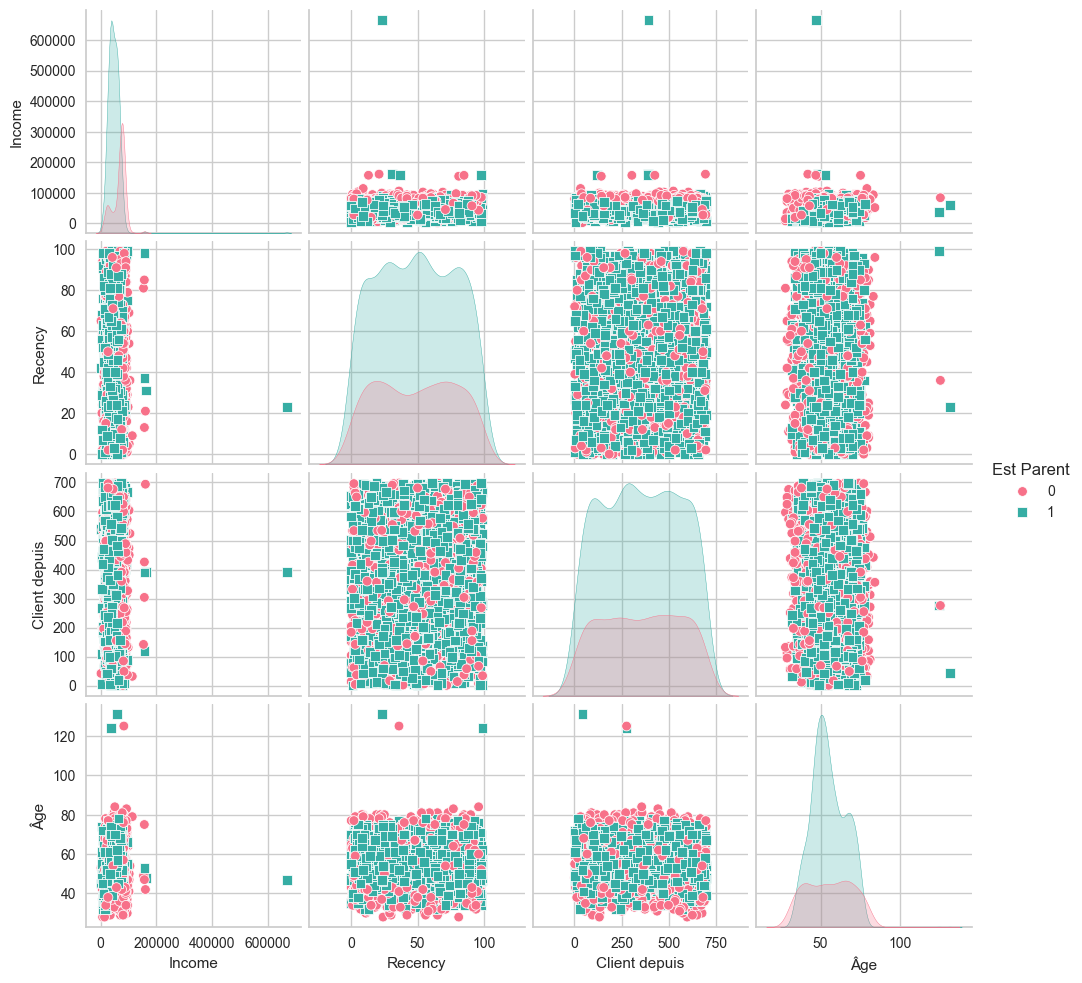

In [20]:
plot = ["Income", "Recency", "Client depuis", "Âge", "Est Parent"]
plt.figure()

sns.pairplot(df[plot], hue="Est Parent", palette="husl", markers=["o", "s"], diag_kind="kde")

plt.show()

On voit bel et bien qu'il y a des outliers pour les variables de l'âge et de l'income. On va supprimer les valeurs aberrantes de ces deux variables en mettant un maximum de 95 ans pour l'âge car le dataset date de quelques années et l'âge est calculé en fonction de notre année actuelle soit 2024. Pour ce qui est du revenu étant donné qu'on observe un seul outlier dans le graphique ci-dessus nous allons mettre un maximum de 650k afin de l'exclure.

In [21]:
df = df[(df["Âge"]<95)]
df = df[(df["Income"]<650000)]

print("Nombre de lignes et de colonnes dans le dataset après suppression des valeurs aberrantes : ", len(df))

Nombre de lignes et de colonnes dans le dataset après suppression des valeurs aberrantes :  2212


On crée une **<u>Matrice de corrélation</u>**

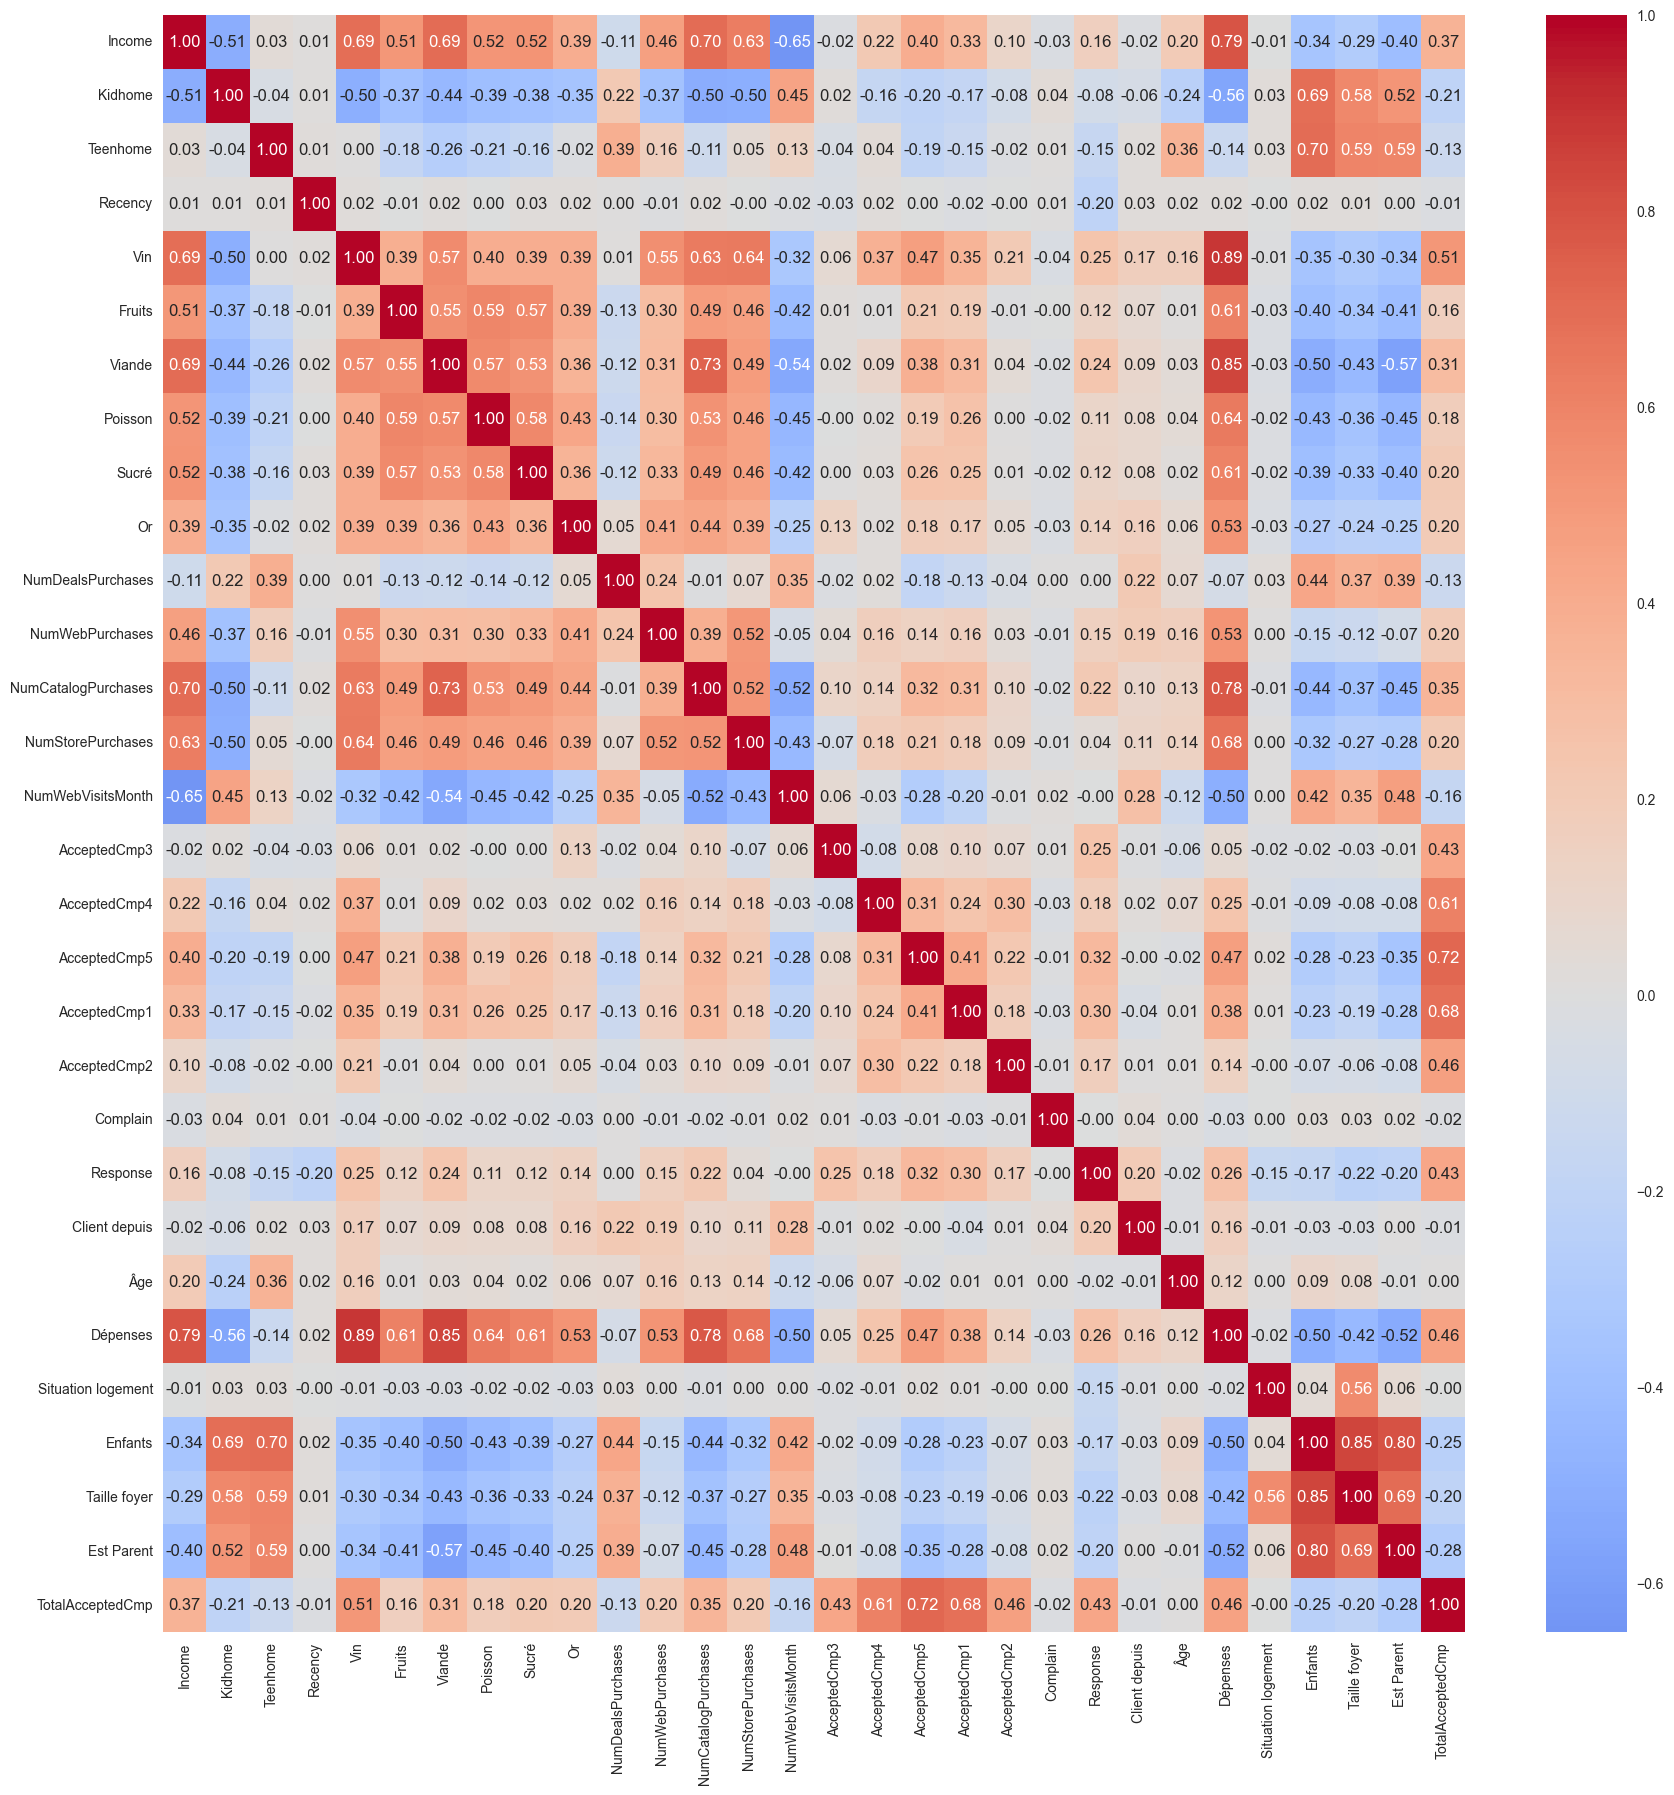

In [22]:
numeric_columns = df.select_dtypes(include=[int, float]).columns
correlation = df[numeric_columns].corr()

plt.figure(figsize=(21, 21))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.show()

On peut voir via cette matrice que nous avons de nombreuses **<u>corrélations</u>**(positives & négatives) au dessus de 0.5 et en dessous de -0.5. Ce qui va nous aider dans notre **choix des vriables** importantes lors de l'utilisation des algorithmes et qui vient conclure notre analyse exploratoire.

## <u style="color: blue">3. Les Algorithmes</u>

### <p style="background-color: #D0D3D4; width: 200px; color: black">3.1 K-Means</p>

#### <u>Réduction de dimension pour K-means</u>

##### Sélection des features:

Pour la sélection de features, il est possible d'utiliser plusieurs méthodes :  

- **Zéro ou presque zéro variance** : On supprime les features qui ont une variance très faible.  

- **Valeurs manquantes** : On supprime les features qui ont un pourcentage de valeurs manquantes très élevé.  

- **Multicollinéarité** : On supprime les features qui sont fortement corrélées entre elles.

##### Zéro ou presque zéro variance

In [23]:
y = df[['Vin', 'Fruits', 'Viande', 'Poisson', 'Sucré', 'Or']]

X = df[['Âge',  'Income', 'Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Complain', 'Response',  'TotalAcceptedCmp', 'Dépenses', 'Enfants', 'Est Parent']]

In [24]:
sel = VarianceThreshold(threshold=0.05)

X_selection = sel.fit_transform(X)

print(f"Nombre de colonnes avant la sélection : {X.shape[1]}")
print(f"Nombre de colonnes après la sélection : {X_selection.shape[1]}")

for i in range(X.shape[1]):
    if i not in sel.get_support(indices=True):
        print(f"Colonne {X.columns[i]} supprimée")

New_X = X.iloc[:, sel.get_support(indices=True)]

Nombre de colonnes avant la sélection : 16
Nombre de colonnes après la sélection : 15
Colonne Complain supprimée


##### Multicolinéarité

On considère que les variables sont fortement corrélées si le coefficient de corrélation est supérieur à 10.

In [25]:
vif_scores = [variance_inflation_factor(New_X.values, i) for i in range(New_X.shape[1])]

print("VIF scores :")
for i, vif in enumerate(vif_scores):
    print(f"{New_X.columns[i]} : {vif}")

VIF scores :
Âge : 18.506285655624055
Income : 21.31247430069995
Kidhome : inf
Teenhome : inf
Recency : 3.912256599302325
NumDealsPurchases : 4.033802465491752
NumWebPurchases : 6.126559914533755
NumCatalogPurchases : 5.395821168524651
NumStorePurchases : 9.31468395050125
NumWebVisitsMonth : 10.065709765308666
Response : 1.6232712746806592
TotalAcceptedCmp : 1.7957376024685072
Dépenses : 10.998959029160417
Enfants : inf
Est Parent : 11.350620987218125


Suppression des variables Year_Birth et Income.

In [26]:
New_X = df[['Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Response', 'Dépenses', 'TotalAcceptedCmp', 'Enfants', 'Est Parent']]

vif_scores = [variance_inflation_factor(New_X.values, i) for i in range(New_X.shape[1])]

print("VIF scores :")
for i, vif in enumerate(vif_scores):
    print(f"{New_X.columns[i]} : {vif}")

VIF scores :
Recency : 3.555313736269056
NumDealsPurchases : 3.7903626405387225
NumWebPurchases : 5.726117278962283
NumCatalogPurchases : 4.895756238237105
NumStorePurchases : 7.57195453169401
NumWebVisitsMonth : 6.652254049315072
Response : 1.5951238823653793
Dépenses : 9.591518286363296
TotalAcceptedCmp : 1.7807988111788777
Enfants : 8.158771340235694
Est Parent : 11.1620951089559


X final:

In [27]:
X = df[['Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Response', 'Dépenses', 'TotalAcceptedCmp', 'Enfants', 'Est Parent']]


##### Analyse Factorielle Multiple

L'AFM est une méthode factorielle adaptée à l'étude des tableaux dans lesquels un ensemble d'individus est décris par un ensemble de variables (qualitatives et/ou quantitatives) structurées en groupes. Elle peut être vue comme une extension de:

- l'ACP (Analyse en Composantes Principales) pour les données quantitatives,  
- l'ACM (Analyse des Correspondances Multiples) pour les données qualitatives,  
- l'AFDM (Analyse Factorielle des Données Mixtes) pour les données des deux types.  
Nous utilisons des données quantitatives, nous allons donc utiliser l'ACP.  

Analyse en Composantes Principales (ACP) :

In [28]:
PCA_k = PCA(n_components=3)
PCA_k.fit(X)
X_PCA = PCA_k.transform(X)
PCA_df = pd.DataFrame(data=X_PCA, columns=['PCA1', 'PCA2', 'PCA3'])

PCA_df.describe()

,PCA1,PCA2,PCA3
count,2.212000e+03,2.212000e+03,2.212000e+03
mean,-2.466984e-15,-1.015061e-14,5.525016e-16
std,6.025252e+02,2.893724e+01,2.840984e+00
min,-6.023078e+02,-4.962385e+01,-1.268172e+01
25%,-5.383071e+02,-2.461255e+01,-1.995757e+00
50%,-2.102702e+02,5.428204e-01,-5.200689e-01
75%,4.407916e+02,2.512968e+01,1.852139e+00
max,1.917702e+03,5.054734e+01,1.126516e+01


In [29]:
fig = px.scatter_3d(PCA_df, x='PCA1', y='PCA2', z='PCA3', width=800, height=800, title='Projection 3D des composantes principales')
fig.show()

#### <u>Sélection du nombre de clusters</u>

##### Méthode du coude

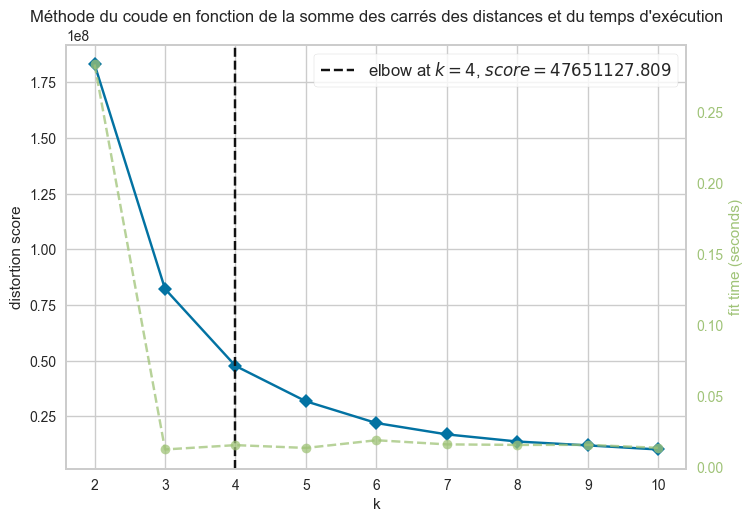

<Axes: title={'center': "Méthode du coude en fonction de la somme des carrés des distances et du temps d'exécution"}, xlabel='k', ylabel='distortion score'>

In [30]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_df)
Elbow_M.title = 'Méthode du coude en fonction de la somme des carrés des distances et du temps d\'exécution'
Elbow_M.show()

##### Méthode de la silhouette

In [31]:
silhouette_scores = []
K = range(2, 11)

for k in K:
    cluster = KMeans(n_clusters=k)
    cluster_labels = cluster.fit_predict(PCA_df)
    
    silhouette_scores.append(silhouette_score(PCA_df, cluster_labels))
    silhouette_average = silhouette_score(PCA_df, cluster_labels)

    print("Pour k clusters =", k, "La moyenne du score de silhouette est :", silhouette_average)

Pour k clusters = 2 La moyenne du score de silhouette est : 0.691335634512824
Pour k clusters = 3 La moyenne du score de silhouette est : 0.6609983388390464
Pour k clusters = 4 La moyenne du score de silhouette est : 0.6305500476699479
Pour k clusters = 5 La moyenne du score de silhouette est : 0.6202341654777638
Pour k clusters = 6 La moyenne du score de silhouette est : 0.6012110877742508
Pour k clusters = 7 La moyenne du score de silhouette est : 0.565569493187624
Pour k clusters = 8 La moyenne du score de silhouette est : 0.5713366039868965
Pour k clusters = 9 La moyenne du score de silhouette est : 0.555068909206506
Pour k clusters = 10 La moyenne du score de silhouette est : 0.497097441562313


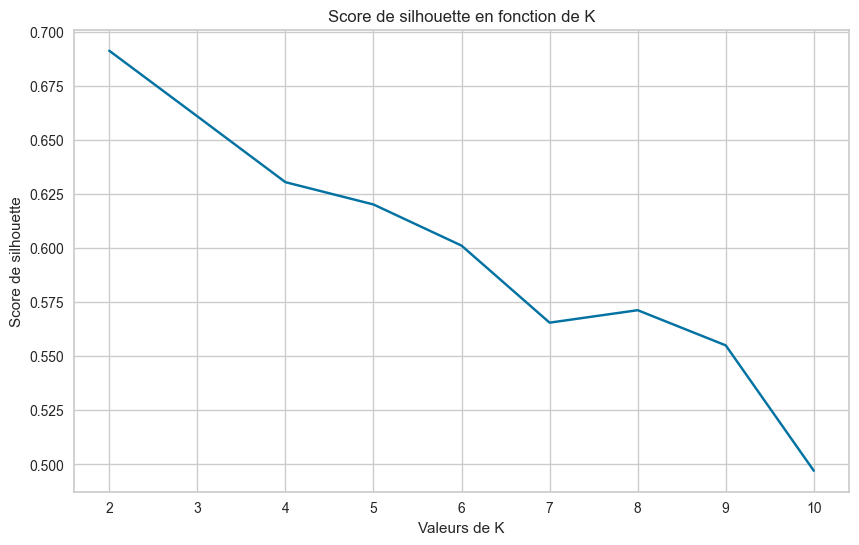

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(K, silhouette_scores)
plt.xlabel('Valeurs de K')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette en fonction de K')
plt.show()

On sélectionne 4 clusters.

___

On applique l'algorithme à nos données

In [33]:
kmeans = KMeans(n_clusters=4).fit(PCA_df)
y_kmeans = kmeans.predict(PCA_df)

fig = px.scatter_3d(PCA_df, x='PCA1', y='PCA2', z='PCA3', color=y_kmeans, width=800, height=800, title='Kmeans avec 4 clusters')
fig.show()

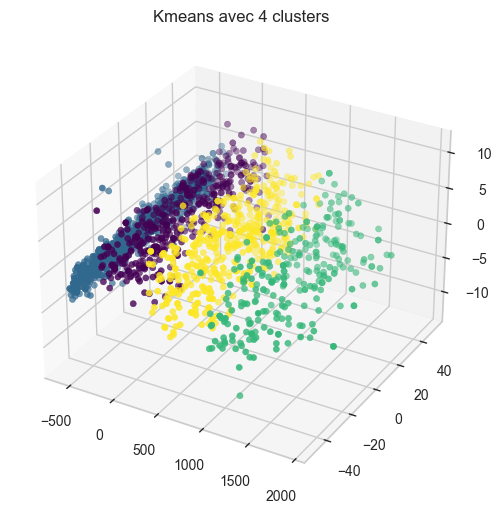

In [34]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(PCA_df['PCA1'], PCA_df['PCA2'], PCA_df['PCA3'], c=y_kmeans, cmap='viridis')
plt.title('Kmeans avec 4 clusters')
plt.show()

In [35]:
silhouette_average_kmeans = silhouette_score(PCA_df, y_kmeans)
print("La moyenne du score de silhouette est :", silhouette_average_kmeans)

La moyenne du score de silhouette est : 0.6301925840757039


### <p style="background-color: #D0D3D4; width: 500px; color: black">3.2 Classification Ascendante Hiérarchique</p>

#### <u>Réduction de dimension pour CAH & DBSCAN</u>

##### Sélection des caractéristiques numériques

In [36]:
# Select the numerics columns
numeric_columns = df.select_dtypes(include=[int, float]).columns
df_numeric = df[numeric_columns]
imputer = SimpleImputer(strategy='mean')
df_numeric_imputed = imputer.fit_transform(df_numeric)

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric_imputed)

# Use ACP
pca = PCA(n_components=4)  
principal_components = pca.fit_transform(df_scaled)

# Create a dataframe with main components
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
df_pca['Est Parent'] = df['Est Parent'].values 

##### Visualisation des résultats de l'ACP

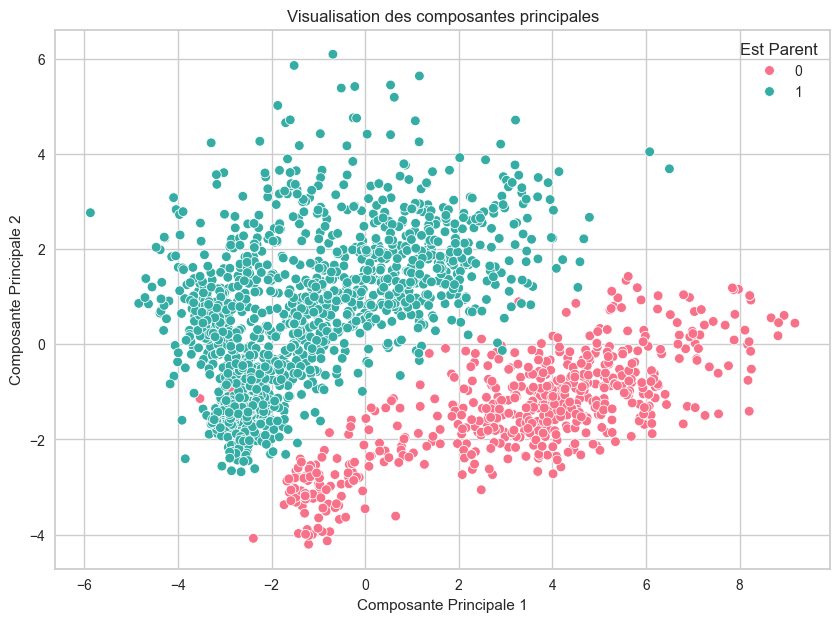

In [37]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Est Parent', palette='husl', data=df_pca)
plt.title('Visualisation des composantes principales')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.show()

##### Explication des composantes principales

In [38]:
pca_components = pd.DataFrame(pca.components_, columns=numeric_columns, index=['PC1', 'PC2', 'PC3', 'PC4'])
print(pca_components)

       Income   Kidhome  Teenhome   Recency       Vin    Fruits    Viande  \
PC1  0.267396 -0.227281 -0.096132 -0.000023  0.256373  0.218227  0.270632   
PC2  0.152713  0.020911  0.446507  0.016382  0.217741 -0.008558 -0.006897   
PC3 -0.076729  0.119957 -0.095935 -0.056930  0.075846 -0.173794 -0.075641   
PC4 -0.185391  0.055786 -0.148322 -0.102466  0.014617  0.055349  0.002296   

      Poisson     Sucré        Or  ...  Complain  Response  Client depuis  \
PC1  0.228553  0.220495  0.176594  ... -0.012399  0.103316       0.029010   
PC2 -0.016587  0.007751  0.120735  ...  0.002004  0.011656       0.127160   
PC3 -0.170215 -0.145434 -0.097202  ... -0.005820  0.304191      -0.014794   
PC4  0.041907  0.027926  0.202468  ...  0.036372  0.309917       0.509204   

          Âge  Dépenses  Situation logement   Enfants  Taille foyer  \
PC1  0.032947  0.309626           -0.025585 -0.232645     -0.205705   
PC2  0.208109  0.128155            0.123551  0.339230      0.345315   
PC3 -0.097113 -

Tout d'abord on fait un échantillonnage des données afin d'alléger la charge de calcul.

In [39]:
sample_size = 1000
df_sample = df_pca.sample(n = sample_size)

On fait un test de différents nombres de clusters

In [40]:
best_score = -1
best_n_components = 0
best_n_clusters = 0
best_clusters = None

On applique le CAH sur l'échantillon

In [41]:
for n_components in [2, 3, 5, 7]:
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(df_scaled)
    df_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
    
    for n_clusters in range(2, 11):
        model = AgglomerativeClustering(n_clusters=n_clusters)
        labels = model.fit_predict(df_pca)
        score = silhouette_score(df_pca, labels)
        
        if score > best_score:
            best_score = score
            best_n_components = n_components
            best_n_clusters = n_clusters
            best_labels = labels

print(f'Best Silhouette Score: {best_score} with {best_n_components} components and {best_n_clusters} clusters')

Best Silhouette Score: 0.4904225430547491 with 2 components and 2 clusters


On applique le clustering avec le meilleur nombre de composantes principales et de clusters

In [42]:
pca = PCA(n_components=best_n_components)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(best_n_components)])
df_pca['Cluster'] = best_labels

On visualise les clusters

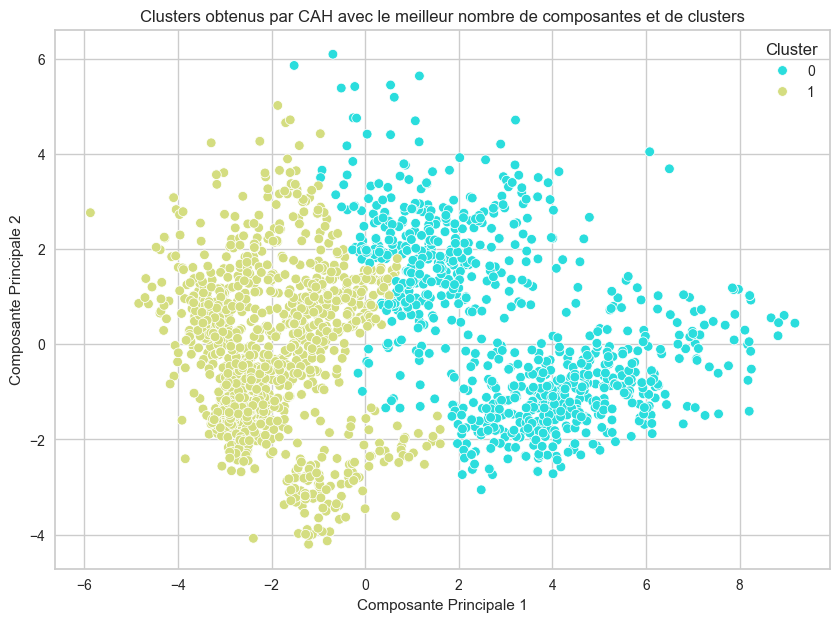

In [43]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='rainbow', data=df_pca)
plt.title('Clusters obtenus par CAH avec le meilleur nombre de composantes et de clusters')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.show()

On crée le dendrogramme pour la visualisation de la hiérarchie des clusters

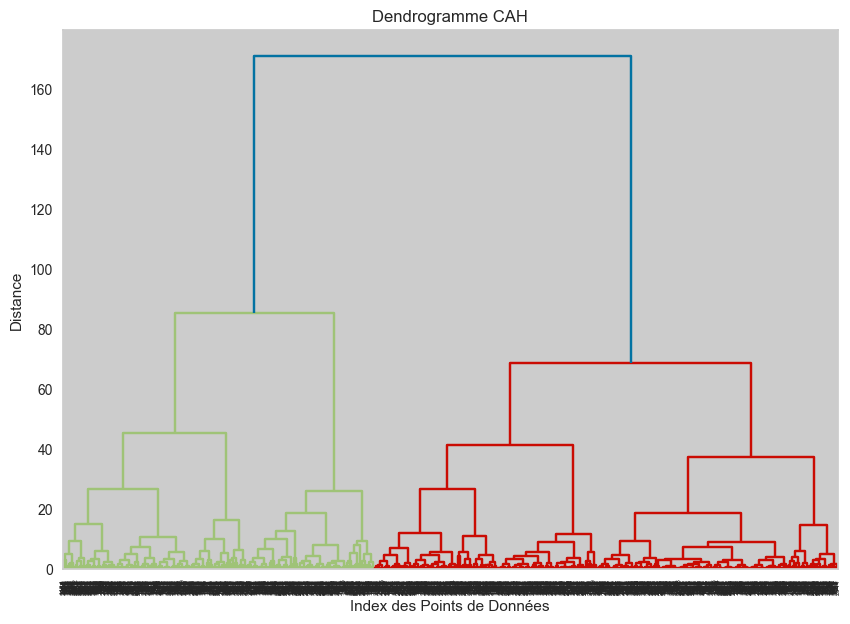

In [44]:
linked = linkage(df_pca.iloc[:, :best_n_components], 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogramme CAH')
plt.xlabel('Index des Points de Données')
plt.ylabel('Distance')
plt.show()

Evaluation des clusters avec le score de silhouette

In [45]:
print(f'Best Silhouette Score: {best_score}')

Best Silhouette Score: 0.4904225430547491


### <p style="background-color: #D0D3D4; width: 200px; color: black">DBSCAN</p>

In [46]:
eps = 0.5  # Rayon du voisinage
min_samples = 5  # Nombre minimum de points dans un voisinage pour être un noyau

# Initialisation de DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Fit et prédiction des clusters
labels = dbscan.fit_predict(principal_components)

# Évaluation avec le score de silhouette
silhouette = silhouette_score(principal_components, labels)
print(f'Silhouette Score pour DBSCAN: {silhouette}')

Silhouette Score pour DBSCAN: 0.09319783043410992


## <u style="color: blue"> 4. Evaluation et comparaison de résultats</u>

Nous avons choisi d'utiliser le score de silhouette afin de comparer les évaluations de nos résultats.  

- K-means: Score de Silhouette ->  0.6305500476699479
- CAH: Score de Silhouette -> 0.4904225430547491
- DBSCAN: Score de Silhouette -> 0.09319783043410992

Le meilleur algorithme avec notre jeu de données est donc le K-means avec un score de 0.63

## <u style="color: blue"> 5. Profiling des groupes de clients</u>

On crée des Boîte à moustache afin de comparer la distribution des clusters

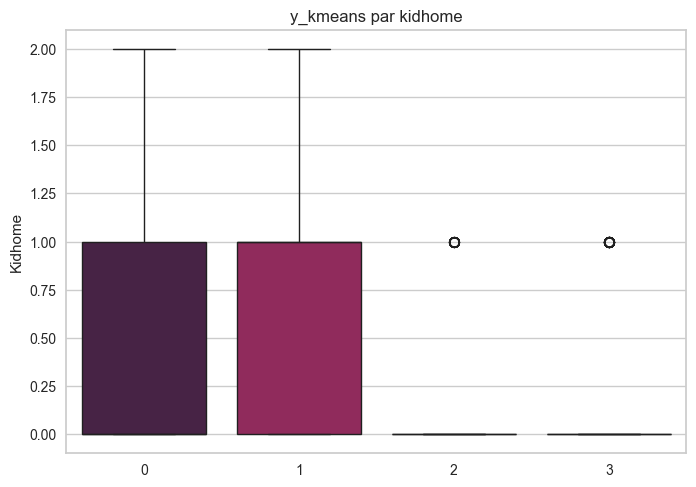

In [47]:
plt.title('y_kmeans par kidhome')
sns.boxplot(x=y_kmeans, y=df['Kidhome'], palette='rocket')
plt.show()

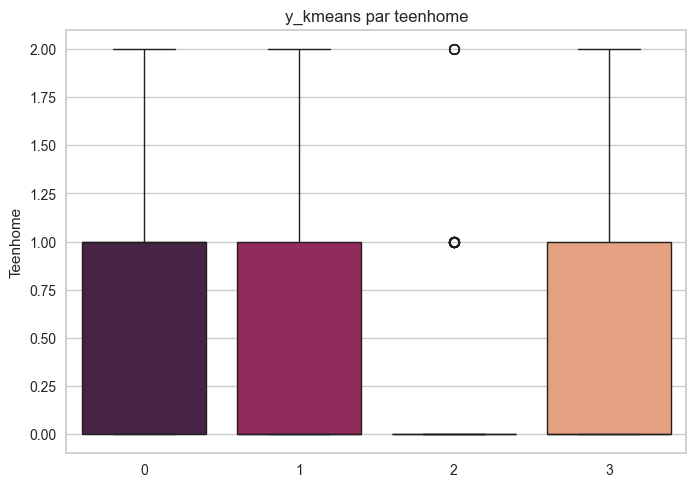

In [48]:
plt.title('y_kmeans par teenhome')
sns.boxplot(x=y_kmeans, y=df['Teenhome'], palette='rocket')
plt.show()

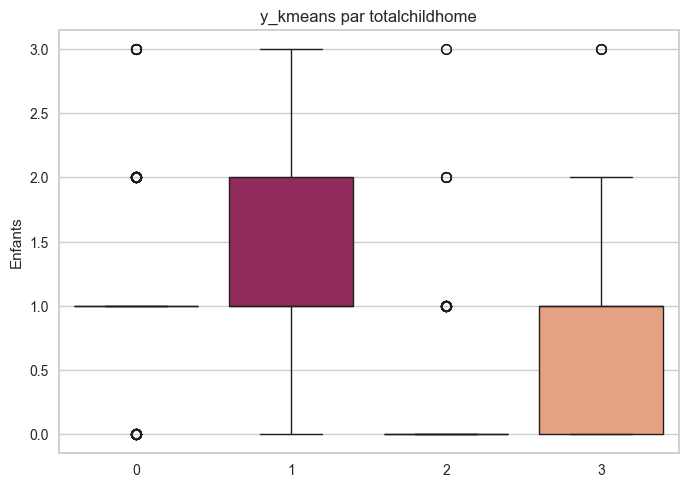

In [49]:
plt.title('y_kmeans par totalchildhome')
sns.boxplot(x=y_kmeans, y=df['Enfants'], palette='rocket')
plt.show()

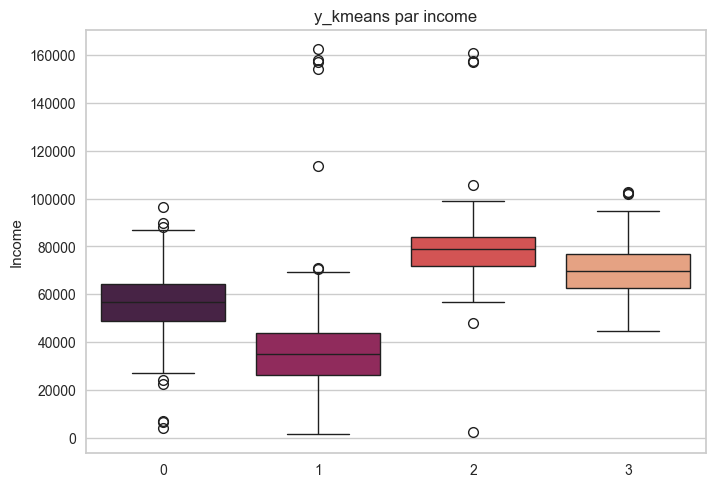

In [50]:
plt.title('y_kmeans par income')
sns.boxplot(x=y_kmeans, y=df['Income'], palette='rocket')
plt.show()

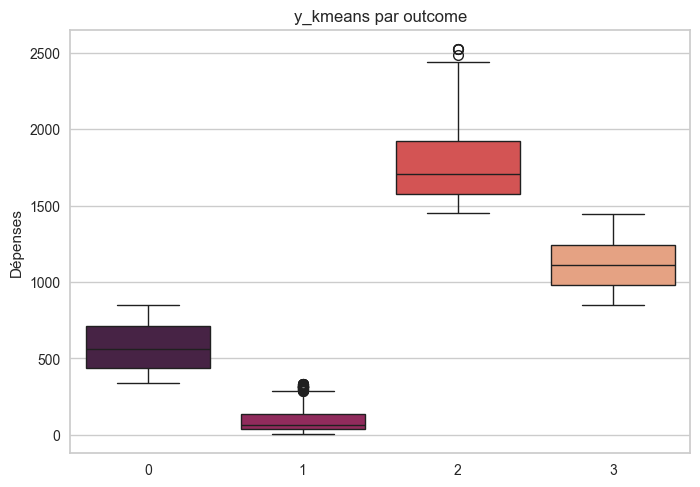

In [51]:
plt.title('y_kmeans par outcome')
sns.boxplot(x=y_kmeans, y=df['Dépenses'], palette='rocket')
plt.show()

Après avoir réalisé cette analyse nous avons pu déterminer 4 clusters: 

- Le cluster 0 correspond globalement à un fôyer avec 1 enfant ou 1 adolescent avec des revenus moyens et des dépenses moyennes ou faibles.

- Le cluster 1 correspond à un fôyer plus nombreux (enfant + adolescent) qui a des revenus plus faibles ainsi que des dépenses très faibles.

- Le cluster 2 correspond à un fôyer qui n'a quasiment pas d'enfant, mais 1 ou 2 adolescents et des revenues moyens ou hauts ainsi que des dépenses moyennes.

- Le cluster 3 correspond à un fôyer qui n'a généralement pas d'enfant et des revenus moyens ou hauts ainsi que des dépenses moyennes ou hautes

## <u style="color: blue"> 6. Conclusion</u>

Pour conclure ce projet, nous pouvons dire que parmi les trois algorithmes que nous avons testé, le K-means est le plus adapté. Nous avons réussi a déterminer 4 clusters cohérents et, afin de tester l'algorithme nous avons décidé de créer deux clients factices pour voir s'ils sont placés dans les bons clusters.

On crée donc deux faux clients de test pour prédire le cluster

In [52]:
client_test = np.array([[25, 15, 50, 10, 100, 5, 1, 2500, 3, 1, 1]])
client_test_pca = PCA_k.transform(client_test)
client_test_cluster_rich = kmeans.predict(client_test_pca)


print(f'Le client test appartient au cluster {client_test_cluster_rich[0]}')

Le client test appartient au cluster 2


Nous pouvons voir que notre premier client factice appartient au cluster 2. Afin d'avoir une visualisation de ceci nous faisons un scatter plot 3D.

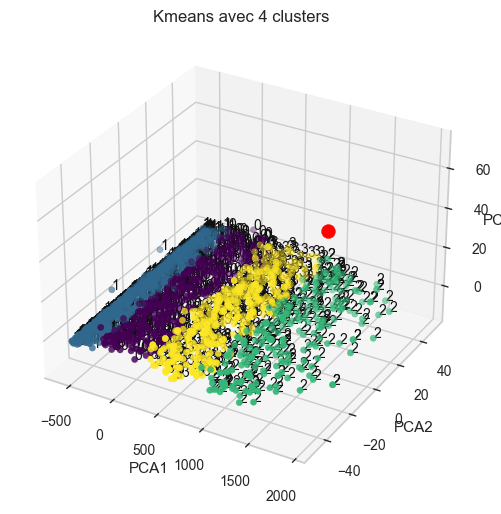

In [53]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(PCA_df['PCA1'], PCA_df['PCA2'], PCA_df['PCA3'], c=y_kmeans, cmap='viridis')
ax.scatter(client_test_pca[0][0], client_test_pca[0][1], client_test_pca[0][2], c='red', s=100)
for i, txt in enumerate(y_kmeans):
    ax.text(PCA_df['PCA1'].iloc[i], PCA_df['PCA2'].iloc[i], PCA_df['PCA3'].iloc[i], str(txt), size=10, zorder=1, color='k')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.title('Kmeans avec 4 clusters')
plt.legend()
plt.show()

Puis pour être sur que ce n'est pas un coup de chance nous créons un deuxième client factice qui devrait être dans un autre cluster.

In [56]:
client_test = np.array([[40, 90, 0, 50, 5, 2, 0, 25, 4, 5, 1]])
client_test_pca = PCA_k.transform(client_test)
client_test_cluster_poor = kmeans.predict(client_test_pca)

print(f'Le client test appartient au cluster {client_test_cluster_poor[0]}')

Le client test appartient au cluster 1


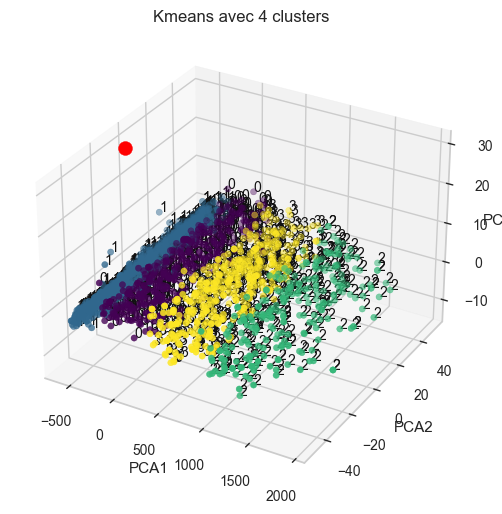

In [57]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(PCA_df['PCA1'], PCA_df['PCA2'], PCA_df['PCA3'], c=y_kmeans, cmap='viridis')
ax.scatter(client_test_pca[0][0], client_test_pca[0][1], client_test_pca[0][2], c='red', s=100)
for i, txt in enumerate(y_kmeans):
    ax.text(PCA_df['PCA1'].iloc[i], PCA_df['PCA2'].iloc[i], PCA_df['PCA3'].iloc[i], str(txt), size=10, zorder=1, color='k')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.title('Kmeans avec 4 clusters')
plt.show()

Ce deuxième client est placé dans le cluster 1 ce qui correspond avec les valeurs que nous lui avons donné.